In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 745 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from category_encoders.one_hot import OneHotEncoder 

from tqdm import tqdm

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"",
             "key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

import kaggle

!kaggle competitions download -c ieee-fraud-detection

!unzip ieee-fraud-detection

 98% 116M/118M [00:03<00:00, 38.7MB/s]
100% 118M/118M [00:03<00:00, 33.1MB/s]
Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


In [ ]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
train_transaction.isFraud = train_transaction.isFraud.astype('str')

test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [ ]:
# трейн
X_train =  train_transaction.drop('isFraud', axis=1)
X_train = X_train.merge(train_identity, how='outer', on='TransactionID')

y_train = train_transaction['isFraud']

# тест
X_test = test_transaction.merge(test_identity, how='outer', on='TransactionID')

In [ ]:
# del train_transaction, train_identity, test_transaction, test_identity

# Описание плана
* Сделать предобработку признаков, оставить только самые полезные
* Для линейных моделей выкидываем коррелирующие признаки
* Бейзлайн - предсказываем мажоритарный класс
* Обучить логистическую регресию с L1 регуляризацией и посмотреть у каких признаков нулевые веса
* Накладывать на линейную фкнкцию после зануления весов более сложные конструкции признаки могут выстрелить в бустинге, но не могут выстрелить в регрессии
* взять подвыборку 70к и понизить размерность до 2х T-SNE/PCA, сдлеать скеттер плот и выделить фрод не фрод показывает возможность классификации


## Признаки

На основе EDA мы выделили для себя следующие полезные признаки

In [ ]:
v_cols = ['V166', 'V77', 'V305', 'V47', 'V240', 
     'V241', 'V120', 'V171', 'V3', 'V56', 
     'V107', 'V260', 'V109', 'V282', 
     'V7', 'V124', 'V46', 'V115', 'V1', 
     'V6', 'V220', 'V283', 'V281', 'V209', 
     'V173', 'V223', 'V78', 'V118', 'V121', 
     'V210', 'V2', 'V174', 'V226', 'V169', 
     'V122', 'V286', 'V55', 'V138', 'V208', 
     'V329', 'V273', 'V42', 'V52', 'V265', 
     'V266', 'V229', 'V276', 'V235', 'V186',
     'V91', 'V234', 'V338', 'V158', 'V326', 
     'V259', 'V246', 'V160', 'V187', 'V303', 
     'V268', 'V89', 'V41', 'V247', 'V195',
     'V325', 'V315', 'V292', 'V272', 'V201', 
     'V163', 'V137', 'V130', 'V113', 'V9', 
     'V87', 'V83', 'V76', 'V67', 'V62', 
     'V54', 'V5', 'V45', 'V38', 'V36', 
     'V301', 'V289', 'V262', 'V26', 'V251', 
     'V24', 'V239', 'V20', 'V188', 'V185', 
     'V175', 'V170', 'V147', 'V142', 
     'V140', 'V13', 'V125', 'V119', 'V116', 'V110']

In [ ]:
cols_float = ['TransactionDT', 'TransactionAmt', 
              'addr1', 'addr2',
              'dist1', 'dist2', 
              'card1', 'card2', 'card3', 'card5',
              'C1', 'C3', 'C5', 'C9', 'C13',
              'D1','D7', 'D8', 'D9', 'D10', 'D11', 'D12']
cols_float.extend(v_cols)


cols_cat = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
            'DeviceType', 'DeviceInfo']
cols_cat.extend(['M' + str(i) for i in range(1, 10)])

In [ ]:
X_train = X_train[cols_float + cols_cat]
X_test = X_test[cols_float + cols_cat]

## Заполним пропуски

In [ ]:
for col in cols_float:
  X_train.loc[X_train[col].isna(), col] = X_train[col].mean()
  X_test.loc[X_test[col].isna(), col] = X_test[col].mean()


for col in cols_cat:
  X_train.loc[X_train[col].isna(), col] = 'no_' + col
  X_test.loc[X_test[col].isna(), col] = 'no_' + col 

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Подкинем пару новых признаков

In [ ]:
X_train['TransactionAmt_cents'] = X_train['TransactionAmt'].astype('str').str.split('.').apply(lambda x: x[1])
X_train['TransactionAmt_int_sum'] = X_train['TransactionAmt'].astype('str').str.split('.').apply(lambda x: x[0])

X_test['TransactionAmt_cents'] = X_test['TransactionAmt'].astype('str').str.split('.').apply(lambda x: x[1])
X_test['TransactionAmt_int_sum'] = X_test['TransactionAmt'].astype('str').str.split('.').apply(lambda x: x[0])

In [ ]:
cols_float.extend(['TransactionAmt_cents', 'TransactionAmt_int_sum'])

In [ ]:
def dttm(date):
    date = date - 86400
    return (date // 86400 // 7,
        date // 86400 % 7, 
        date % 86400 // 3600,
        date % 86400 % 3600 // 60,
        date % 86400 % 3600 % 60)


X_train['dttm_week'] = X_train.TransactionDT.apply(dttm).apply(lambda x: x[0])
X_train['dttm_day'] = X_train.TransactionDT.apply(dttm).apply(lambda x: x[1])
X_train['dttm_hour'] = X_train.TransactionDT.apply(dttm).apply(lambda x: x[2])
X_train['dttm_minute'] = X_train.TransactionDT.apply(dttm).apply(lambda x: x[3])
X_train['dttm_sec'] = X_train.TransactionDT.apply(dttm).apply(lambda x: x[4])

X_test['dttm_week'] = X_test.TransactionDT.apply(dttm).apply(lambda x: x[0])
X_test['dttm_day'] = X_test.TransactionDT.apply(dttm).apply(lambda x: x[1])
X_test['dttm_hour'] = X_test.TransactionDT.apply(dttm).apply(lambda x: x[2])
X_test['dttm_minute'] = X_test.TransactionDT.apply(dttm).apply(lambda x: x[3])
X_test['dttm_sec'] = X_test.TransactionDT.apply(dttm).apply(lambda x: x[4])

In [ ]:
cols_float.extend(['dttm_week', 'dttm_day', 'dttm_hour', 'dttm_minute', 'dttm_sec'])

In [ ]:
deviceinfo_most_pop = X_train.query('DeviceInfo != "no_DeviceInfo"')['DeviceInfo']\
                                                                              .value_counts()\
                                                                              .head(5)\
                                                                              .index\
                                                                              .tolist()
deviceinfo_most_pop.append('no_DeviceInfo')

X_train.loc[:, 'DeviceInfo'] = X_train['DeviceInfo'].apply(lambda x: x if x in deviceinfo_most_pop else 'other')
X_test.loc[:, 'DeviceInfo'] = X_test['DeviceInfo'].apply(lambda x: x if x in deviceinfo_most_pop else 'other')

## Нормализуем вещественные признаки

In [ ]:
standard_scaler = StandardScaler(copy=True)

for col in cols_float[:-7]:
  if X_train[X_train[col] < 0].shape[0]:
    continue

  X_train[col] = np.log(X_train[col])
  X_test[col] = np.log(X_test[col])

X_train[cols_float] = X_train[cols_float].replace(np.inf * -1, -1000000000)
X_test[cols_float] = X_test[cols_float].replace(np.inf * -1, -1000000000)

X_train[cols_float] = X_train[cols_float].replace(np.inf, 1000000000)
X_test[cols_float] = X_test[cols_float].replace(np.inf, 1000000000)

X_train_matrix = standard_scaler.fit_transform(X_train[cols_float])
X_test_matrix = standard_scaler.transform(X_test[cols_float])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
for col in cols_float:
  na_percent = X_train[X_train[col].isna()].shape[0]/X_train.shape[0] * 100
  if na_percent > 0:
    print(col, na_percent)

In [ ]:
X_train_matrix = pd.DataFrame(X_train_matrix) 
X_train_matrix.columns = X_train[cols_float].columns

X_test_matrix = pd.DataFrame(X_test_matrix) 
X_test_matrix.columns = X_test[cols_float].columns

In [ ]:
# X_train_matrix.to_csv('X_train_matrix.csv') 
# X_test_matrix.to_csv('X_test_matrix.csv') 

In [ ]:
# !zip X_train_matrix.zip X_train_matrix.csv
# !zip X_test_matrix.zip X_test_matrix.csv

In [ ]:
# from google.colab import files

# files.download('X_train_matrix.zip')
# files.download('X_test_matrix.zip')

## Кодируем категориальные признаки

In [ ]:
for col in cols_cat:
  print(col, X_train[col].nunique())

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
DeviceType 3
DeviceInfo 7
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
ohe_enc = OneHotEncoder()

X_train_matrix_cat = ohe_enc.fit_transform(X_train[cols_cat])
X_test_matrix_cat = ohe_enc.transform(X_test[cols_cat])

In [ ]:
X_train_matrix_cat = pd.DataFrame(X_train_matrix_cat) 
X_train_matrix_cat.columns = ohe_enc.get_feature_names()

X_test_matrix_cat = pd.DataFrame(X_test_matrix_cat) 
X_test_matrix_cat.columns = ohe_enc.get_feature_names()

In [ ]:
X_train = pd.concat([X_train_matrix, X_train_matrix_cat], axis=1)
X_test = pd.concat([X_test_matrix, X_test_matrix_cat], axis=1)

In [ ]:
assert X_test.shape[1] == X_train.shape[1]

### Log Reg с L2 регуляризацией

In [ ]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7)

In [ ]:
# обучение логистической регрессии
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

lr = LogisticRegression(max_iter=10000,
                        warm_start=True)

ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10)

inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=100))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
  lr.fit(X_train.iloc[chunk, :], y_train.iloc[chunk])

100%|██████████| 10/10 [01:57<00:00, 11.75s/it]


In [ ]:
pred_lr = lr.predict_proba(X_val)

In [ ]:
# Посчитаем пороговое значение (если будет предсказывать мажоритарный класс)
from sklearn.metrics import roc_auc_score

benchmark = ['0' for _ in range(len(y_val))]

roc_auc_score(y_val, benchmark)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


0.5

In [ ]:
# посчитаем roc auc для обученого лог рега
y_val_pred_for_fraud = [x[1] for x in pred_lr]

roc_auc_score(y_val, y_val_pred_for_fraud)

0.8393704590855569

Как минимум первая моделька уже неплохо обучилась и превысила пороговое значение. Мы уже немного молодцы)

## Log Reg с l1-регуляризацией



In [ ]:
lr = LogisticRegression(max_iter=10000,
                        warm_start=True,
                        penalty='l1',
                        solver='liblinear'
                        )

ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10)

inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=100))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
  lr.fit(X_train.iloc[chunk, :], y_train.iloc[chunk])

In [ ]:
pred_lr = lr.predict_proba(X_val)

In [ ]:
y_val_pred_for_fraud = [x[1] for x in pred_lr]

roc_auc_score(y_val, y_val_pred_for_fraud)

0.8405952990455513

In [ ]:
import pickle
from datetime import datetime as dt

model_name = f'best_model_{dt.today()}.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(lr, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files

files.download(model_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle 

with open('best_model_2022-12-23 16_38_11.565860.pkl', 'rb') as f:
  lr = pickle.load(f)

In [ ]:
important_features = []
for i, val in enumerate(lr.coef_[0]):
  if val:
    continue
  important_features.append(i)

In [ ]:
important_cols = X_train.iloc[:, important_features].columns.tolist()

## Подбираем параметры для Log Reg

In [ ]:
# C = [i/100 for i in range(1, 100, 10)]
# C.extend([1, 3, 100])

# for val in tqdm(C):

#     lr = LogisticRegression(C=val, max_iter=500)
#     lr.fit(X_train, y_train)

#     pred_lr = lr.predict_proba(X_val)
#     y_val_pred_for_fraud = [x[1] for x in pred_lr]
#     print(val, roc_auc_score(y_val, y_val_pred_for_fraud))

In [ ]:
lr = LogisticRegression(max_iter=10000,
                        warm_start=True,
                        penalty='l1',
                        solver='liblinear',
                        C=3 #вроде как бест параметр
                        )

ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10)

inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=100))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
  lr.fit(X_train.iloc[chunk, :], y_train.iloc[chunk])

100%|██████████| 10/10 [15:35<00:00, 93.51s/it] 


In [ ]:
pred_lr = lr.predict_proba(X_val)

y_val_pred_for_fraud = [x[1] for x in pred_lr]

roc_auc_score(y_val, y_val_pred_for_fraud)

0.8416049924271972

In [ ]:
import pickle
from datetime import datetime as dt

model_name = f'best_model_{dt.today()}.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(lr, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files

files.download(model_name) 

## SVM

In [ ]:
# очень долго обучается, поэтому решили попробовать снизить размерность данных 
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # сократим кол-во признаков

X_train_new = pca.fit_transform(X_train[important_cols])
# X_val_new = pca.transform(X_val)
# X_test_new = pca.transform(X_test)

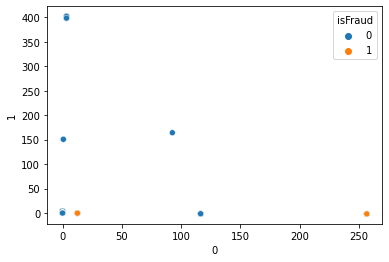

In [ ]:
import seaborn as sns

X_train_df = pd.DataFrame(X_train_new)
sns.scatterplot(data=X_train_df, x=0, y=1, hue=y_train)

plt.show()

Визуально, на основе разложения, можно выделить два класса.

In [ ]:
# очень долго обучается, поэтому решили попробовать снизить размерность данных 
from sklearn.decomposition import PCA

pca = PCA(n_components=70) # сократим кол-во признаков

X_train_new = pca.fit_transform(X_train[important_cols])
X_val_new = pca.transform(X_val[important_cols])
X_test_new = pca.transform(X_test[important_cols])

In [ ]:
from sklearn.svm import SVC

for kernel in tqdm(['linear', 'rbf', 'poly', 'sigmoid']):
    svm = SVC(kernel=kernel,
              probability=True,
              verbose=True,
              max_iter=100)

    svm.fit(X_train_new, y_train)

    pred = svm.predict_proba(X_val_new)
    y_val_pred_for_fraud = [x[1] for x in pred]

    print(kernel, roc_auc_score(y_val, y_val_pred_for_fraud))

  0%|          | 0/4 [00:00<?, ?it/s]

[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 25%|██▌       | 1/4 [01:50<05:31, 110.60s/it]

9 0.38989439509159224
[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 50%|█████     | 2/4 [04:08<04:13, 126.63s/it]

9 0.5302761369696088
[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 75%|███████▌  | 3/4 [06:03<02:01, 121.20s/it]

9 0.4301017386047031
[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [08:14<00:00, 123.53s/it]

9 0.640877593974018


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC()

params = {'C' : [5, 10, 15],
          'gamma': [1, 0.1, 0.01],
          'kernel': ['linear', 'rbf', 'sigmoid']}

gs = GridSearchCV(svm, params, cv=2, scoring='roc_auc', verbose=2)

gs.fit(X_train_new, y_train)

gs.best_score_, gs.best_estimator_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


In [ ]:
import pickle
from datetime import datetime as dt

model_name = f'svm_best_model_{dt.today()}.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(svm, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files

files.download(model_name) 

## Catboost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 20 kB/s 


In [ ]:
from catboost import CatBoostClassifier

params = {
    'iterations': 2500,
    'depth': 8,
    'loss_function' : 'Logloss',
    'eval_metric' : 'AUC',
    'learning_rate': .1,
    'random_seed': 42,
    'od_wait': 5,
    'verbose': 100
}

model = CatBoostClassifier(**params)

model.fit(X_train, y_train)

0:	total: 112ms	remaining: 4m 40s
100:	total: 13.5s	remaining: 5m 21s
200:	total: 28.6s	remaining: 5m 27s
300:	total: 45.2s	remaining: 5m 30s
400:	total: 59.2s	remaining: 5m 9s
500:	total: 1m 14s	remaining: 4m 57s
600:	total: 1m 27s	remaining: 4m 36s
700:	total: 1m 40s	remaining: 4m 18s
800:	total: 1m 54s	remaining: 4m 2s
900:	total: 2m 7s	remaining: 3m 46s
1000:	total: 2m 22s	remaining: 3m 33s
1100:	total: 2m 36s	remaining: 3m 19s
1200:	total: 2m 54s	remaining: 3m 8s
1300:	total: 3m 7s	remaining: 2m 52s
1400:	total: 3m 20s	remaining: 2m 37s
1500:	total: 3m 35s	remaining: 2m 23s
1600:	total: 3m 48s	remaining: 2m 8s
1700:	total: 4m 2s	remaining: 1m 53s
1800:	total: 4m 16s	remaining: 1m 39s
1900:	total: 4m 30s	remaining: 1m 25s
2000:	total: 4m 44s	remaining: 1m 10s
2100:	total: 4m 57s	remaining: 56.5s
2200:	total: 5m 10s	remaining: 42.2s
2300:	total: 5m 24s	remaining: 28.1s
2400:	total: 5m 39s	remaining: 14s
2499:	total: 5m 53s	remaining: 0us


In [ ]:
pred = model.predict_proba(X_val)

y_val_pred_for_fraud = [x[1] for x in pred]

print(roc_auc_score(y_val, y_val_pred_for_fraud))

0.953148859883551


In [ ]:
import pickle
from datetime import datetime as dt

model_name = f'catboost_best_model_{dt.today()}.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files

files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Тестовый сабмит 

In [ ]:
pred_lr = lr.predict_proba(X_test)

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.shape

(506691, 2)

In [ ]:
pred = model.predict_proba(X_test)

In [ ]:
result = test_transaction['TransactionID'].reset_index()

result['isFraud'] = [fraud for notfraud, fraud in pred]

In [ ]:
cols = ['TransactionID','isFraud']
result[cols].to_csv('prediction.csv', index=False)

In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f  prediction.csv -m "Message"

100% 14.2M/14.2M [00:01<00:00, 8.57MB/s]
Successfully submitted to IEEE-CIS Fraud Detection